In [1]:
import pandas as pd 
import re 
import numpy as np

# Compute the similarity between LLM and the enriched GO names (any GO term that is significant)

1. Remove the 'regulation of' from the name and run semantic similarity between GO and LLM names
2. pick the highest semantic similarity GO term 
3. plot the llm JI vs GO JI plot with colored by semantic similarity 

## Trim names

In [2]:
input_file = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF.tsv'
input_df = pd.read_csv(input_file, sep='\t')

# find cases where there is regulation of
example_df = input_df.loc[(input_df['Term'].str.contains('regulation of', flags=re.IGNORECASE, regex=True))&(input_df['LLM Name'].str.contains('regulation of', flags=re.IGNORECASE, regex=True))]
print(example_df.shape)
example_df

(1143, 16)


,Source,GeneSetID,GeneSetName,GeneList,updated GeneList,n_Genes,LLM Name,LLM Analysis,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,query_size,intersections
3659,NeST,Cluster2-104,Cluster2-104,IER2 KIAA1671 MAF MAP3K9 SLC7A11,IER2 KIAA1671 MAF MAP3K9 SLC7A11,5,Response to Oxidative Stress and Regulation of...,1. IER2 (Immediate Early Response 2) is a tran...,0.85,regulation of cysteine metabolic process,GO:1901494,0.017022,1,1,4,SLC7A11
3662,NeST,Cluster2-104,Cluster2-104,IER2 KIAA1671 MAF MAP3K9 SLC7A11,IER2 KIAA1671 MAF MAP3K9 SLC7A11,5,Response to Oxidative Stress and Regulation of...,1. IER2 (Immediate Early Response 2) is a tran...,0.85,regulation of glutathione biosynthetic process,GO:1903786,0.022695,1,2,4,SLC7A11
3663,NeST,Cluster2-104,Cluster2-104,IER2 KIAA1671 MAF MAP3K9 SLC7A11,IER2 KIAA1671 MAF MAP3K9 SLC7A11,5,Response to Oxidative Stress and Regulation of...,1. IER2 (Immediate Early Response 2) is a tran...,0.85,regulation of sulfur amino acid metabolic process,GO:0031335,0.022695,1,2,4,SLC7A11
3667,NeST,Cluster2-104,Cluster2-104,IER2 KIAA1671 MAF MAP3K9 SLC7A11,IER2 KIAA1671 MAF MAP3K9 SLC7A11,5,Response to Oxidative Stress and Regulation of...,1. IER2 (Immediate Early Response 2) is a tran...,0.85,regulation of glutamate metabolic process,GO:2000211,0.023327,1,3,4,SLC7A11
3672,NeST,Cluster2-104,Cluster2-104,IER2 KIAA1671 MAF MAP3K9 SLC7A11,IER2 KIAA1671 MAF MAP3K9 SLC7A11,5,Response to Oxidative Stress and Regulation of...,1. IER2 (Immediate Early Response 2) is a tran...,0.85,regulation of neutrophil apoptotic process,GO:0033029,0.023327,1,8,4,SLC7A11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32996,L1000,BRD-A19248578_L5288-1MG_MCF7_6.0_h_10.0_um,BRD-A19248578 L5288-1MG MCF7 6.0 h 10.0 um,AFF1 AKAP13 BST2 CD55 FOXO4 HECA HMGCS1 LEF1 M...,AFF1 AKAP13 BST2 CD55 FOXO4 HECA HMGCS1 LEF1 M...,22,Regulation of Cellular Metabolism and Stress R...,1. AFF1 is a component of the super elongation...,0.85,negative regulation of epithelial cell apoptot...,GO:1904036,0.047935,2,62,22,"NPC1,TNFAIP3"
32998,L1000,BRD-A19248578_L5288-1MG_MCF7_6.0_h_10.0_um,BRD-A19248578 L5288-1MG MCF7 6.0 h 10.0 um,AFF1 AKAP13 BST2 CD55 FOXO4 HECA HMGCS1 LEF1 M...,AFF1 AKAP13 BST2 CD55 FOXO4 HECA HMGCS1 LEF1 M...,22,Regulation of Cellular Metabolism and Stress R...,1. AFF1 is a component of the super elongation...,0.85,negative regulation of CD40 signaling pathway,GO:2000349,0.047935,1,2,22,TNFAIP3
32999,L1000,BRD-A19248578_L5288-1MG_MCF7_6.0_h_10.0_um,BRD-A19248578 L5288-1MG MCF7 6.0 h 10.0 um,AFF1 AKAP13 BST2 CD55 FOXO4 HECA HMGCS1 LEF1 M...,AFF1 AKAP13 BST2 CD55 FOXO4 HECA HMGCS1 LEF1 M...,22,Regulation of Cellular Metabolism and Stress R...,1. AFF1 is a component of the super elongation...,0.85,regulation of smooth muscle cell migration,GO:0014910,0.047935,2,65,22,"FOXO4,SORL1"
33002,L1000,BRD-A19248578_L5288-1MG_MCF7_6.0_h_10.0_um,BRD-A19248578 L5288-1MG MCF7 6.0 h 10.0 um,AFF1 AKAP13 BST2 CD55 FOXO4 HECA HMGCS1 LEF1 M...,AFF1 AKAP13 BST2 CD55 FOXO4 HECA HMGCS1 LEF1 M...,22,Regulation of Cellular Metabolism and Stress R...,1. AFF1 is a component of the super elongation...,0.85,negative regulation of osteoclast proliferation,GO:0090291,0.047935,1,2,22,TNFAIP3


In [38]:
import re
def remove_regulation_of(text):
    text = text.lower()
    # Define the regular expression pattern
    pattern = r'.*regulation of '
    # # find if match 
    # match = re.match(pattern, text)
    # Substitute the matched pattern with an empty string
    result = re.sub(pattern, '', text)
    return result


def iter_df_trim_name(row):
    trim_GO_term = remove_regulation_of(row['Term'])
    
    llm_name = row['LLM Name'].split('and')
    if len(llm_name) > 1:
        split_name = []
        for name in llm_name:
            trim_llm_name = remove_regulation_of(name)
            split_name.append(trim_llm_name)
        return ' and '.join(split_name), trim_GO_term
    else:
        trim_llm_name = remove_regulation_of(row['LLM Name'])
    # trim_llm_name = remove_regulation_of(row['LLM Name'])
   
    return trim_llm_name, trim_GO_term
# Example usage
# example_string = "This is a test string with Regulation of Gene Expression"
# cleaned_string = remove_regulation_of(example_string)
# print(cleaned_string)  # Output: "gene expression"

# Apply the function to the 'Term' column
example_df[['trimed LLM Name','trimed Term']] = input_df.apply(lambda row: iter_df_trim_name(row), axis=1, result_type='expand')
example_df [['LLM Name', 'Term','trimed LLM Name','trimed Term']].sample(10)

/tmp/ipykernel_4117581/99769858.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_df[['trimed LLM Name','trimed Term']] = input_df.apply(lambda row: iter_df_trim_name(row), axis=1, result_type='expand')


,LLM Name,Term,trimed LLM Name,trimed Term
18595,Regulation of NF-κB Signaling and Autophagy,negative regulation of glucose transmembrane t...,nf-κb signaling and autophagy,glucose transmembrane transport
18303,Regulation of NF-κB Signaling and Autophagy,regulation of ncRNA transcription,nf-κb signaling and autophagy,ncrna transcription
12191,Regulation of circadian rhythm and cellular re...,regulation of insulin secretion,circadian rhythm and cellular response to st...,insulin secretion
18788,Regulation of NF-κB Signaling and Autophagy,positive regulation of nucleotide metabolic pr...,nf-κb signaling and autophagy,nucleotide metabolic process
18691,Regulation of NF-κB Signaling and Autophagy,negative regulation of lipid catabolic process,nf-κb signaling and autophagy,lipid catabolic process
5480,Regulation of Cell Signaling and Cell Cycle Pr...,positive regulation of cell proliferation invo...,cell signaling and cell cycle progression,cell proliferation involved in heart morphogen...
12101,Regulation of circadian rhythm and cellular re...,regulation of phosphoprotein phosphatase activity,circadian rhythm and cellular response to st...,phosphoprotein phosphatase activity
3917,Regulation of Developmental Gene Expression,regulation of cellular metabolic process,developmental gene expression,cellular metabolic process
18738,Regulation of NF-κB Signaling and Autophagy,negative regulation of macroautophagy,nf-κb signaling and autophagy,macroautophagy
18131,Regulation of transcription and cell signaling...,positive regulation of DNA-templated transcrip...,transcription and cell signaling in development,dna-templated transcription


In [27]:
# run on the input 
input_df[['trimed LLM Name','trimed Term']] = input_df.apply(lambda row: iter_df_trim_name(row), axis=1, result_type='expand')
input_df.to_csv('data/omics_revamped_LLM_gprofiler_new_gene_name_DF_trimed_name.tsv', sep='\t', index=False)

In [33]:
from semanticSimFunctions import getNameSimilarities_no_repeat
from transformers import AutoTokenizer, AutoModel
%reload_ext autoreload
%autoreload 2
SapBERT_tokenizer = AutoTokenizer.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')
SapBERT_model = AutoModel.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')

## test run with 10 examples

new_sim_df, llm_emb_dict, go_emb_dict = getNameSimilarities_no_repeat(example_sim_df, 'trimed LLM Name', 'trimed Term',SapBERT_tokenizer, SapBERT_model, llm_name_embedding_dict = {},go_term_embedding_dict = {}, simMetric = 'cosine_similarity', epsilon= 0.05)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0
0.18908814
1
0.29766625
2
0.37250754
3
0.38568264
4
0.39409524
5
0.17431703
6
0.42438126
7
0.25174814
8
0.4211318
9
0.39356935


## run semantic similarity in the command line (using the same environment) 

python run_omics_sem_sim.py --inputFile data/omics_revamped_LLM_gprofiler_new_gene_name_DF_trimed_name.tsv --nameCol1 'trimed LLM Name' --nameCol2 'trimed Term'


Note:
- will save the embeddings for all LLM names and GO term name as separate files 


## find the highest semantic similar GO among the ones that are significant 

In [3]:
import pandas as pd
sim_val_file = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF_trimed_name_simVals_DF.tsv'
sim_val_df = pd.read_csv(sim_val_file, sep='\t')
print(sim_val_df.shape)
sim_val_df.head()

(53452, 19)


,Source,GeneSetID,GeneSetName,GeneList,updated GeneList,n_Genes,LLM Name,LLM Analysis,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,query_size,intersections,trimed LLM Name,trimed Term,LLM_name_GO_term_sim
0,NeST,Cluster1-10,Cluster1-10,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,12,Lipid Metabolism and Membrane Dynamics,"1. CTRL, or carboxyl-terminal esterase/lipase,...",0.85,L-leucine import across plasma membrane,GO:1903801,0.080467,1,5,10,SLC7A8,lipid metabolism and membrane dynamics,l-leucine import across plasma membrane,0.288667
1,NeST,Cluster1-11,Cluster1-11,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,12,Lipid Metabolism and Membrane Trafficking,1. LMF1 (Lipase Maturation Factor 1) is crucia...,0.85,innate immune response,GO:0045087,0.028149,5,965,10,"MFHAS1,MR1,PLA2G1B,SPIRE1,USP38",lipid metabolism and membrane trafficking,innate immune response,0.298155
2,NeST,Cluster1-11,Cluster1-11,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,12,Lipid Metabolism and Membrane Trafficking,1. LMF1 (Lipase Maturation Factor 1) is crucia...,0.85,defense response to symbiont,GO:0140546,0.028149,5,1113,10,"MFHAS1,MR1,PLA2G1B,SPIRE1,USP38",lipid metabolism and membrane trafficking,defense response to symbiont,0.340553
3,NeST,Cluster1-11,Cluster1-11,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,12,Lipid Metabolism and Membrane Trafficking,1. LMF1 (Lipase Maturation Factor 1) is crucia...,0.85,defense response to other organism,GO:0098542,0.029069,5,1220,10,"MFHAS1,MR1,PLA2G1B,SPIRE1,USP38",lipid metabolism and membrane trafficking,defense response to other organism,0.255613
4,NeST,Cluster1-11,Cluster1-11,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,12,Lipid Metabolism and Membrane Trafficking,1. LMF1 (Lipase Maturation Factor 1) is crucia...,0.85,formin-nucleated actin cable organization,GO:0110009,0.042317,1,3,10,SPIRE1,lipid metabolism and membrane trafficking,formin-nucleated actin cable organization,0.275124


In [4]:
adj_pval_thresh = 0.05
llm_confidence_thresh = 0.1

llm_conf_field = 'Score'
go_pval_field = 'Adjusted P-value'

both_named = sim_val_df[(sim_val_df[llm_conf_field] >= llm_confidence_thresh)&(sim_val_df[go_pval_field] <= adj_pval_thresh)]

print(both_named.shape)
print(both_named['GeneSetID'].nunique())

(33759, 19)
124


In [5]:
from utils.analyze_enrichment_utils import cal_JI_coverage
def get_max_semantic_sim(df):
    return df.loc[df['LLM_name_GO_term_sim'].idxmax()]
group_col = ["Source", "GeneSetID", "GeneSetName", "GeneList"] # group by these columns in future steps
grouped_df = both_named.groupby(group_col)

max_semantic_sim_df = grouped_df.apply(get_max_semantic_sim).reset_index(drop = True)

max_semantic_sim_df  = cal_JI_coverage(max_semantic_sim_df)

# merge the LLM supporting genes and JI 

max_semantic_sim_df[[ 'n_Genes', 'GeneList', 'LLM Name', 'Term','Adjusted P-value', 'intersection_size', 'term_size', 'trimed LLM Name', 'trimed Term',
       'LLM_name_GO_term_sim', 'gprofiler_JI']].head(10)

,n_Genes,GeneList,LLM Name,Term,Adjusted P-value,intersection_size,term_size,trimed LLM Name,trimed Term,LLM_name_GO_term_sim,gprofiler_JI
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,tissue morphogenesis,1.493670e-02,5,611,cellular matrix remodeling and tissue develo...,tissue morphogenesis,0.791489,0.007962
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,cell-cell adhesion,4.541045e-02,7,946,cellular adhesion and extracellular matrix i...,cell-cell adhesion,0.773306,0.007121
2,38,1060P11.3 ADH5 ADM ATF3 CASP1 CLEC2B CPA3 CRIM...,Stress Response and Apoptosis Regulation,response to stress,9.732725e-03,16,3855,stress response and apoptosis regulation,response to stress,0.697585,0.004130
3,76,1060P11.3 ADAM17 AKAP12 ALCAM AMFR BIK CASP2 C...,Cellular Stress Response and Apoptosis Regulation,regulation of cellular response to stress,2.285087e-02,7,512,cellular stress response and apoptosis regul...,cellular response to stress,0.722424,0.012132
4,34,CASP1 CAST CD52 CLC COL1A2 COL3A1 COL5A2 CPA3 ...,Extracellular Matrix Organization and Cell Sig...,extracellular matrix organization,4.251353e-02,4,324,extracellular matrix organization and cell s...,extracellular matrix organization,0.781709,0.011299
5,63,1060P11.3 ACTN1 AMIGO2 ANKRD10 ATP11B C1QA C1Q...,Immune Response and Extracellular Matrix Organ...,immune response,3.088147e-02,15,1988,immune response and extracellular matrix org...,immune response,0.655543,0.007382
6,67,1060P11.3 ACLY CDH2 CDKN1C CLU CST3 CXCL12 CXC...,Cholesterol Biosynthesis and Lipid Metabolism ...,cholesterol metabolic process,8.996143e-14,13,137,cholesterol biosynthesis and lipid metabolis...,cholesterol metabolic process,0.764886,0.069149
7,74,1060P11.3 ACKR1 ASNS ATP6V1D AXIN1 BCL6 BEX1 B...,Cellular Stress Response and Metabolic Regulation,cellular response to stress,8.101941e-06,22,1770,cellular stress response and metabolic regul...,cellular response to stress,0.771145,0.012088
8,27,CHEK1 DAB2 EGLN3 MFAP5 MXRA5 PDCD4 PLEKHM1 PTP...,Cellular Stress Response and Apoptosis Regulation,fructose biosynthetic process,2.612569e-03,2,2,cellular stress response and apoptosis regul...,fructose biosynthetic process,0.205950,0.074074
9,40,1060P11.3 BEX1 CD44 CDC42EP3 CHI3L1 EXT1 IGFBP...,Tumor Microenvironment Modulation and Extracel...,mesenchymal cell migration,3.265654e-02,2,60,tumor microenvironment modulation and extrac...,mesenchymal cell migration,0.541297,0.021505


In [17]:
## load the LLM coverage and JI data as a common df to merge
llm_coverage_df = pd.read_csv("data/omics_revamped_LLM_genecounts_DF.tsv", sep="\t")

llm_JI_file = 'data/omics_revamped_LLM_w_best_matching_GO_terms_for_JI.tsv'
llm_ji_df = pd.read_csv(llm_JI_file, sep="\t")


In [16]:
# merge with the LLM coverage data
merged_DF = pd.merge(max_semantic_sim_df, llm_coverage_df, on=['Source','GeneSetID','GeneSetName', 'GeneList', 'n_Genes'], how='left')
print(merged_DF.shape)
# print(merged_DF.columns)


# merge with the LLM JI data

merged_DF = pd.merge(merged_DF, llm_ji_df, on=['Source','GeneSetID','GeneList','n_Genes', 'LLM Name','Supporting Count'], how='left')
print(merged_DF.shape)
print(merged_DF.columns)

(124, 26)
(124, 31)
Index(['Source', 'GeneSetID', 'GeneSetName', 'GeneList', 'updated GeneList',
       'n_Genes', 'LLM Name', 'LLM Analysis', 'Score', 'Term', 'GO ID',
       'Adjusted P-value', 'intersection_size', 'term_size', 'query_size',
       'intersections', 'trimed LLM Name', 'trimed Term',
       'LLM_name_GO_term_sim', 'gprofiler_JI', 'gprofiler_coverage',
       'Supporting Genes', 'Supporting Count', 'LLM Support Analysis',
       'GenesMentionedInText', 'LLM_coverage', 'LLM_best_matching_GO',
       'best_matching_GO_ID', 'best_matching_GO_term_genes',
       'best_matching_GO_term_size', 'LLM_JI'],
      dtype='object')


# Plot the JI correlation scatter 

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7

high similarity: 120 
in percentage: 96.77%
low similarity: 4 
in percentage: 3.23%
high similarity high number genes: 81 
in percentage: 65.32%


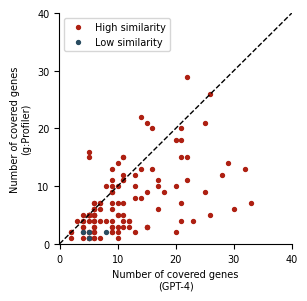

In [14]:
similarity_thre = 0.5

# y_field = 'gprofiler_JI'
# y_label = 'g:Profiler coverage'
# x_field = 'LLM_JI'
# x_label = 'GPT-4 coverage'

y_field = 'intersection_size'
y_label = 'Number of covered genes\n(g:Profiler)'
x_field = 'Supporting Count'
x_label = 'Number of covered genes\n(GPT-4)'


# Filter the DataFrame
filtered_data_high = merged_DF[merged_DF['LLM_name_GO_term_sim'] >= similarity_thre]
filtered_data_low = merged_DF[merged_DF['LLM_name_GO_term_sim'] < similarity_thre]
print(f'high similarity: {filtered_data_high.shape[0]}', f'\nin percentage: {filtered_data_high.shape[0]/merged_DF.shape[0] *100 :.2f}%')
print(f'low similarity: {filtered_data_low.shape[0]}', f'\nin percentage: {filtered_data_low.shape[0]/merged_DF.shape[0] *100 :.2f}%')

# further breakdown the high similarity group into high and low JI
filtered_data_high_JI_high = filtered_data_high[filtered_data_high[x_field]>filtered_data_high[y_field]]
print(f'high similarity high number genes: {filtered_data_high_JI_high.shape[0]}', f'\nin percentage: {filtered_data_high_JI_high.shape[0]/merged_DF.shape[0] *100 :.2f}%')
filtered_data_high_JI_low = filtered_data_high[filtered_data_high[x_field]<=filtered_data_high[y_field]]
# LLM JI vs gprofiler JI, colored by the similarity with countinuous color
plt.figure(figsize=(3,3))

# Create the scatter plot using the filtered data with explicit normalization
# Here, we switch to using matplotlib directly

plt.scatter(
    x=filtered_data_high[x_field], 
    y=filtered_data_high[y_field], 
    c='#ae2012',
    s=8,  # Set the size of the points
    label='High similarity'
)

# plot the low similarity data
plt.scatter(
    x=filtered_data_low[x_field], 
    y=filtered_data_low[y_field], 
    c='#294c60',
    s=8,  # Set the size of the points
    label='Low similarity'
)

plt.xlabel(x_label)
plt.ylabel(y_label)
# plt.axvline(x=JI_thresh, color='black', linestyle='--', label='JI threshold')
# plt.axhline(y=JI_thresh, color='black', linestyle='--')
plt.xlim(-0.05, 40)
plt.ylim(-0.05, 40)
# Ensure the x and y ticks are the same
ticks = range(0, 41, 10)
plt.xticks(ticks)
plt.yticks(ticks)
# plot diagonal line
plt.plot([0, 40], [0, 40], lw=1, color = 'black', linestyle='--')


sns.despine()
plt.legend()
plt.savefig('figures/omics_LLM_genes_vs_gprofiler_genes_sep_similarity.svg', dpi=300)
plt.show()

In [69]:
def clean_gene_list(row):
    gene_list = row['intersections'].split(',')
    return ' '.join(gene_list)

merged_DF['intersections'] = merged_DF.apply(lambda row: clean_gene_list(row), axis=1)
merged_DF.to_csv('data/omics_revamped_LLM_gprofiler_new_gene_name_DF_trimed_name_simVals_max_named.tsv', sep='\t', index=False)